timings_main_1000.csv: 1000 records
timings_cond_clean_1000.csv: 1000 records

Summary for timings_main_1000.csv:
- Average Solve Time: 1.27 seconds (mean of all durations)
- Median Solve Time: 0.64 seconds (middle value when sorted)
- Standard Deviation: 3.06 seconds (spread of durations around the mean)
- Minimum Solve Time: 0.00 seconds (shortest solve duration)
- Maximum Solve Time: 50.00 seconds (longest solve duration, capped at 50s)
- 25th Percentile: 0.22 seconds (25% of solves were faster than this)
- 75th Percentile: 1.56 seconds (75% of solves were faster than this)
- Number of Outliers: 1 (solves capped at 50s)

Summary for timings_cond_clean_1000.csv:
- Average Solve Time: 1.20 seconds (mean of all durations)
- Median Solve Time: 0.68 seconds (middle value when sorted)
- Standard Deviation: 2.86 seconds (spread of durations around the mean)
- Minimum Solve Time: 0.00 seconds (shortest solve duration)
- Maximum Solve Time: 50.00 seconds (longest solve duration, capped at 50

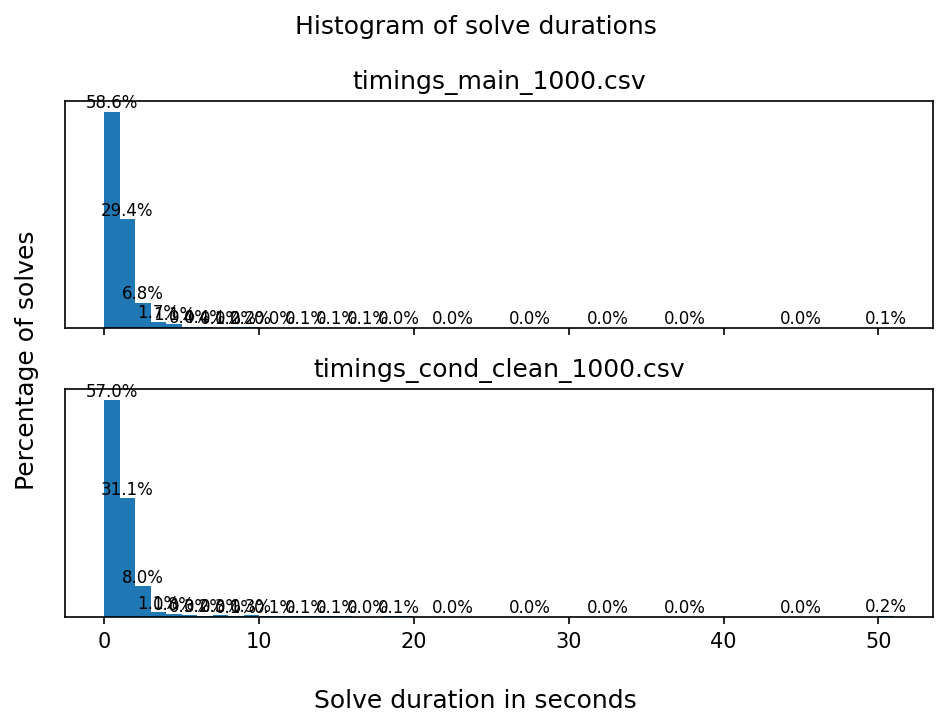

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

base_path = "timings_main_1000.csv"
path = "timings_cond_clean_1000.csv"

# These are all the timings we want to see
paths = [base_path, path]

# Read the CSV
dfs = [
    pl.scan_csv(path).select(pl.col("package"), pl.col("duration")).collect()
    for path in paths
]

for path, df in zip(paths, dfs):
    count = df.select(pl.len()).item()
    print(f"{path}: {count} records")

# Define the histogram bins
threshold = 50
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, threshold, threshold + 1]

dfs_capped = [
    df.select([
        pl.col("duration").map_elements(lambda x: min(x, threshold), return_dtype=pl.Float64)
    ]) for df in dfs]

# Create the histogram
fig, axs = plt.subplots(2, sharex=True)

stats = []

for path, df_capped, ax in zip(paths, dfs_capped, axs):
    # Extract the capped duration values
    values = df_capped["duration"].to_numpy().flatten()
    
    # Calculate key statistics
    mean = np.mean(values)
    median = np.median(values)
    std_dev = np.std(values)
    min_value = np.min(values)
    max_value = np.max(values)
    percentile_25 = np.percentile(values, 25)
    percentile_75 = np.percentile(values, 75)
    outliers = sum(values >= threshold)
    
    # Store for comparison later
    stats.append({
        "path": path,
        "mean": mean,
        "median": median,
        "std_dev": std_dev,
        "min": min_value,
        "max": max_value,
        "p25": percentile_25,
        "p75": percentile_75,
        "outliers": outliers
    })
    
    # Print detailed statistics with explanations
    print(f"\nSummary for {path}:")
    print(f"- Average Solve Time: {mean:.2f} seconds (mean of all durations)")
    print(f"- Median Solve Time: {median:.2f} seconds (middle value when sorted)")
    print(f"- Standard Deviation: {std_dev:.2f} seconds (spread of durations around the mean)")
    print(f"- Minimum Solve Time: {min_value:.2f} seconds (shortest solve duration)")
    print(f"- Maximum Solve Time: {max_value:.2f} seconds (longest solve duration, capped at {threshold}s)")
    print(f"- 25th Percentile: {percentile_25:.2f} seconds (25% of solves were faster than this)")
    print(f"- 75th Percentile: {percentile_75:.2f} seconds (75% of solves were faster than this)")
    print(f"- Number of Outliers: {outliers} (solves capped at {threshold}s)")

    # Plot histogram
    values, bins, bars = ax.hist(values, bins=bins, density=True)
    ax.set_title(path)
    ax.bar_label(bars, fontsize=8, color='black', labels=[f'{x.get_height():.1%}' for x in bars])
    ax.tick_params(axis='y', which='both', left=False, top=False, labelleft=False)

# Compare the datasets (assuming two datasets for comparison)
if len(stats) == 2:
    print("\nComparison between the datasets:")
    mean_diff = stats[0]["mean"] / stats[1]["mean"]
    median_diff = stats[0]["median"] / stats[1]["median"]
    print(f"- Average Solve Time: '{stats[1]['path']}' was {mean_diff:.2f} times faster than '{stats[0]['path']}'")
    print(f"- Median Solve Time: '{stats[1]['path']}' was {median_diff:.2f} times faster than '{stats[0]['path']}'")

    p25_diff = stats[0]["p25"] / stats[1]["p25"]
    p75_diff = stats[0]["p75"] / stats[1]["p75"]
    print(f"- 25th Percentile: '{stats[1]['path']}' was {p25_diff:.2f} times faster than '{stats[0]['path']}'")
    print(f"- 75th Percentile: '{stats[1]['path']}' was {p75_diff:.2f} times faster than '{stats[0]['path']}'")

    outlier_diff = stats[0]["outliers"] - stats[1]["outliers"]
    print(f"- Outliers: '{stats[1]['path']}' had {outlier_diff} fewer solves capped at {threshold}s")

# Add labels to the ticks
fig.supxlabel("Solve duration in seconds")
fig.supylabel("Percentage of solves")
fig.suptitle("Histogram of solve durations")

plt.tight_layout()
plt.show()

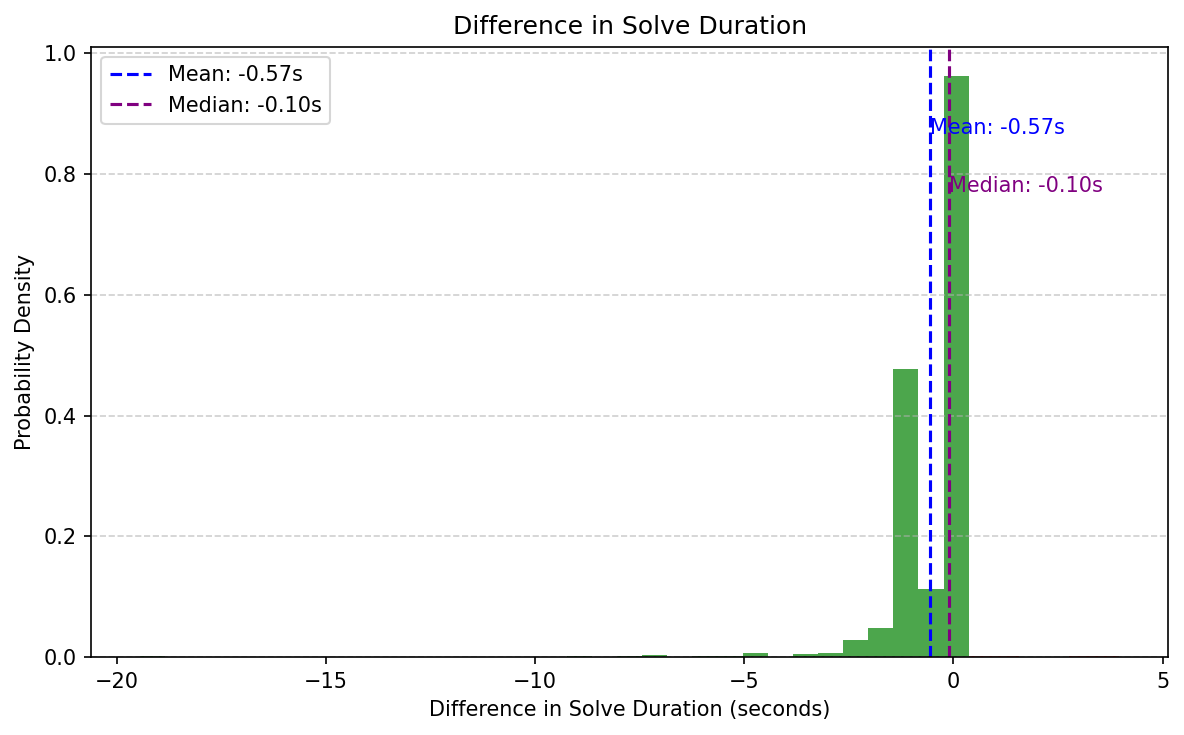

In [7]:
# Load the timings
dfs = [
    pl.scan_csv(path).select(pl.col("package"), pl.col("duration")) 
    for path in [base_path, path]
]

# Compute the solver differences
df_diff = dfs[1].join(dfs[0], on="package").select(
    pl.col("package"), 
    (pl.col("duration") - pl.col("duration_right")).alias("duration_diff")
).collect()

# Extract the differences as a NumPy array
duration_diff = df_diff["duration_diff"].to_numpy()

# Calculate summary statistics
mean_diff = np.mean(duration_diff)
median_diff = np.median(duration_diff)
std_diff = np.std(duration_diff)

# Create the histogram
fig, ax = plt.subplots(figsize=(8, 5))
bins = np.linspace(min(duration_diff), max(duration_diff), 40)
n, bins, patches = ax.hist(duration_diff, bins=bins, density=True, alpha=0.7)

# Color negative bars differently for emphasis
for bar, value in zip(patches, bins[:-1]):
    if value < 0:
        bar.set_facecolor('green')
    else:
        bar.set_facecolor('red')

# Add vertical lines for mean and median
ax.axvline(mean_diff, color='blue', linestyle='--', linewidth=1.5, label=f"Mean: {mean_diff:.2f}s")
ax.axvline(median_diff, color='purple', linestyle='--', linewidth=1.5, label=f"Median: {median_diff:.2f}s")

# Annotate summary stats on the plot
ax.annotate(f"Mean: {mean_diff:.2f}s", xy=(mean_diff, max(n)*0.9), fontsize=10, color='blue')
ax.annotate(f"Median: {median_diff:.2f}s", xy=(median_diff, max(n)*0.8), fontsize=10, color='purple')

# Adding title and labels
ax.set_title("Difference in Solve Duration")
ax.set_xlabel("Difference in Solve Duration (seconds)")
ax.set_ylabel("Probability Density")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display the histogram
plt.tight_layout()
plt.show()

In [13]:
# Extract values
duration_diff = df_diff["duration_diff"].to_numpy()
package_names = df_diff["package"].to_numpy()

# Identify the top 5 fastest packages (most negative differences)
sorted_indices = np.argsort(duration_diff)[:5]  # Smallest differences (faster solves)

# ANSI escape code for bold text
bold = "\033[1m"
reset = "\033[0m"

# Display the top 5 fastest packages with clean formatting and bold "faster"
print("\nTop 5 Fastest Packages (Most Improved):\n")
for idx in sorted_indices:
    package_name = package_names[idx].replace("\n", ", ").replace(" *", "")
    print(f"- {package_name:<30}{bold} | {duration_diff[idx]:.2f}s faster{reset}")


Top 5 Fastest Packages (Most Improved):

- pypika-gis, shinywidgets, libglvnd-gles-cos7-ppc64le, spherical, cpd, gerrychain, codetiming, cyclus-build-deps, azure-storage-file-datalake, mbdata | -19.45s faster
- opensm-libs-cos7-x86_64, trufflehog, roocs-utils, hiclass, aiotube, r-tibble, hydromt_wflow | -9.08s faster
- whl2conda, gymnasium-classic_control, r-clustergeneration, arvpyf, ecodata-menu, airflow-with-jenkins | -7.71s faster
- chart.js, mgwr, nss-softokn-freebl-cos7-ppc64le, bluesky-darkframes, starlite-multipart, r-rcarb, scipy >=0.13,<0.18 | -7.30s faster
- parsimonious, rb-multipart-post, airflow-with-ldap, msvc-headers-libs, dataprofiler, epysurv | -6.93s faster
